# Recurrent Neural Networks

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

## Time series forecasting

In [2]:
df = pd.read_csv('./retail_price_canadaian_market.csv',
                 skiprows=6, skipfooter=9,
                 engine='python')
df.head()

,Adjustments,Unadjusted,Seasonally adjusted
0,Jan-1991,12588862,15026890
1,Feb-1991,12154321,15304585
2,Mar-1991,14337072,15413591
3,Apr-1991,15108570,15293409
4,May-1991,17225734,15676083


In [3]:
df.head()

,Adjustments,Unadjusted,Seasonally adjusted
0,Jan-1991,12588862,15026890
1,Feb-1991,12154321,15304585
2,Mar-1991,14337072,15413591
3,Apr-1991,15108570,15293409
4,May-1991,17225734,15676083


In [6]:
from pandas.tseries.offsets import MonthEnd

In [11]:
 pd.to_datetime(df['Adjustments']) + MonthEnd(1)

0     1991-01-31
1     1991-02-28
2     1991-03-31
3     1991-04-30
4     1991-05-31
         ...    
308   2016-09-30
309   2016-10-31
310   2016-11-30
311   2016-12-31
312   2017-01-31
Name: Adjustments, Length: 313, dtype: datetime64[ns]

In [12]:
df['Adjustments'] = pd.to_datetime(df['Adjustments']) + MonthEnd(1)
df = df.set_index('Adjustments')
df.head()

,Unadjusted,Seasonally adjusted
Adjustments,,
1991-01-31,12588862,15026890
1991-02-28,12154321,15304585
1991-03-31,14337072,15413591
1991-04-30,15108570,15293409
1991-05-31,17225734,15676083


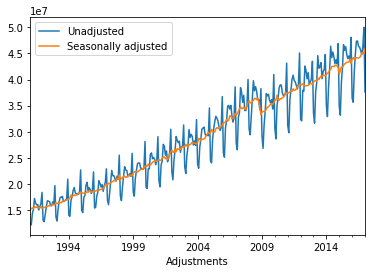

In [13]:
df.plot()

In [14]:
split_date = pd.Timestamp('01-01-2011')

In [15]:
train = df.loc[:split_date, ['Unadjusted']]
test = df.loc[split_date:, ['Unadjusted']]

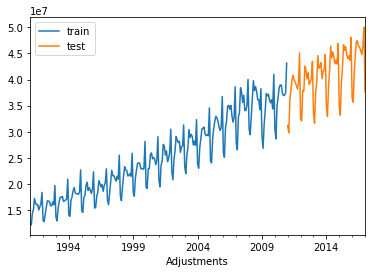

In [16]:
ax = train.plot()
test.plot(ax=ax)
plt.legend(['train', 'test'])

In [17]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()

train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

In [18]:
train_sc[:4]

array([[0.01402033],
       [0.        ],
       [0.0704258 ],
       [0.09531795]])

In [19]:
X_train = train_sc[:-1]
y_train = train_sc[1:]

X_test = test_sc[:-1]
y_test = test_sc[1:]

### Fully connected predictor

In [21]:
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping

In [22]:
K.clear_session()

model = Sequential()
model.add(Dense(12, input_dim=1, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12)                24        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 13        
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________


In [23]:
early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)

In [24]:
model.fit(X_train, y_train, epochs=200,
          batch_size=2, verbose=1,
          callbacks=[early_stop])

Epoch 1/200
120/120 [==============================] - 0s 678us/step - loss: 0.0832
Epoch 2/200
120/120 [==============================] - 0s 493us/step - loss: 0.0221
Epoch 3/200
120/120 [==============================] - 0s 359us/step - loss: 0.0178
Epoch 4/200
120/120 [==============================] - 0s 366us/step - loss: 0.0146
Epoch 5/200
120/120 [==============================] - 0s 391us/step - loss: 0.0124
Epoch 6/200
120/120 [==============================] - 0s 359us/step - loss: 0.0113
Epoch 7/200
120/120 [==============================] - 0s 369us/step - loss: 0.0104
Epoch 8/200
120/120 [==============================] - 0s 343us/step - loss: 0.0103
Epoch 9/200
120/120 [==============================] - 0s 353us/step - loss: 0.0103
Epoch 00009: early stopping


In [25]:
y_pred = model.predict(X_test)

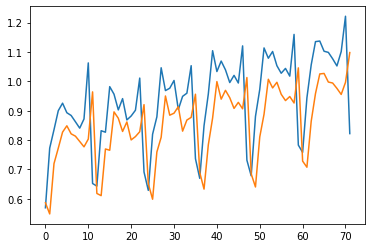

In [26]:
plt.plot(y_test)
plt.plot(y_pred)

### Recurrent predictor

In [27]:
from keras.layers import LSTM

In [28]:
X_train.shape

(239, 1)

In [29]:
#3D tensor with shape (batch_size, timesteps, input_dim)
X_train[:, None].shape

(239, 1, 1)

In [30]:
X_train_t = X_train[:, None]
X_test_t = X_test[:, None]

In [31]:
K.clear_session()
model = Sequential()

model.add(LSTM(6, input_shape=(1, 1)))

model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

In [32]:
model.fit(X_train_t, y_train,
          epochs=100, batch_size=1, verbose=1,
          callbacks=[early_stop])

Epoch 1/100
239/239 [==============================] - 0s 572us/step - loss: 0.0725
Epoch 2/100
239/239 [==============================] - 0s 545us/step - loss: 0.0242
Epoch 3/100
239/239 [==============================] - 0s 560us/step - loss: 0.0189
Epoch 4/100
239/239 [==============================] - 0s 569us/step - loss: 0.0149
Epoch 5/100
239/239 [==============================] - 0s 556us/step - loss: 0.0123
Epoch 6/100
239/239 [==============================] - 0s 548us/step - loss: 0.0110
Epoch 7/100
239/239 [==============================] - 0s 559us/step - loss: 0.0102
Epoch 8/100
239/239 [==============================] - 0s 548us/step - loss: 0.0103
Epoch 00008: early stopping


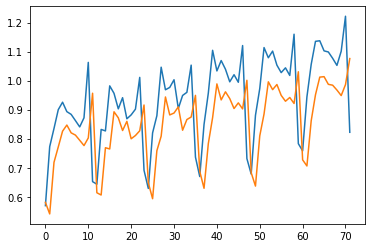

In [33]:
y_pred = model.predict(X_test_t)
plt.plot(y_test)
plt.plot(y_pred)

## Feature Scaling, window method

In [34]:
train_sc.shape

(240, 1)

In [35]:
train_sc_df = pd.DataFrame(train_sc, columns=['Scaled'], index=train.index)
test_sc_df = pd.DataFrame(test_sc, columns=['Scaled'], index=test.index)
train_sc_df.head()

,Scaled
Adjustments,
1991-01-31,0.014020
1991-02-28,0.000000
1991-03-31,0.070426
1991-04-30,0.095318
1991-05-31,0.163628


In [36]:
for s in range(1, 13):
    train_sc_df['shift_{}'.format(s)] = train_sc_df['Scaled'].shift(s)
    test_sc_df['shift_{}'.format(s)] = test_sc_df['Scaled'].shift(s)

In [51]:
train_sc_df['Scaled']

Adjustments
1991-01-31    0.014020
1991-02-28    0.000000
1991-03-31    0.070426
1991-04-30    0.095318
1991-05-31    0.163628
                ...   
2010-08-31    0.814394
2010-09-30    0.799167
2010-10-31    0.802101
2010-11-30    0.814829
2010-12-31    1.000000
Name: Scaled, Length: 240, dtype: float64

In [37]:
train_sc_df.head(13)

,Scaled,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,shift_11,shift_12
Adjustments,,,,,,,,,,,,,
1991-01-31,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-02-28,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-03-31,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-04-30,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-05-31,0.163628,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-06-30,0.135141,0.163628,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-07-31,0.123958,0.135141,0.163628,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN
1991-08-31,0.126174,0.123958,0.135141,0.163628,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN
1991-09-30,0.092309,0.126174,0.123958,0.135141,0.163628,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN


In [38]:
X_train = train_sc_df.dropna().drop('Scaled', axis=1)
y_train = train_sc_df.dropna()[['Scaled']]

X_test = test_sc_df.dropna().drop('Scaled', axis=1)
y_test = test_sc_df.dropna()[['Scaled']]

In [39]:
X_train.head()

,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,shift_11,shift_12
Adjustments,,,,,,,,,,,,
1992-01-31,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958,0.135141,0.163628,0.095318,0.070426,0.000000,0.014020
1992-02-29,0.030027,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958,0.135141,0.163628,0.095318,0.070426,0.000000
1992-03-31,0.019993,0.030027,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958,0.135141,0.163628,0.095318,0.070426
1992-04-30,0.065964,0.019993,0.030027,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958,0.135141,0.163628,0.095318
1992-05-31,0.109831,0.065964,0.019993,0.030027,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958,0.135141,0.163628


In [40]:
X_train.shape

(228, 12)

In [41]:
X_train = X_train.values
X_test= X_test.values

y_train = y_train.values
y_test = y_test.values

### Fully Connected on Windows

In [42]:
K.clear_session()

model = Sequential()
model.add(Dense(12, input_dim=12, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12)                156       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 13        
Total params: 169
Trainable params: 169
Non-trainable params: 0
_________________________________________________________________


In [43]:
model.fit(X_train, y_train, epochs=200,
          batch_size=1, verbose=1, callbacks=[early_stop])

Epoch 1/200
228/228 [==============================] - 0s 345us/step - loss: 0.0216
Epoch 2/200
228/228 [==============================] - 0s 340us/step - loss: 0.0130
Epoch 3/200
228/228 [==============================] - 0s 338us/step - loss: 0.0100
Epoch 4/200
228/228 [==============================] - 0s 347us/step - loss: 0.0091
Epoch 5/200
228/228 [==============================] - 0s 347us/step - loss: 0.0075
Epoch 6/200
228/228 [==============================] - 0s 348us/step - loss: 0.0064
Epoch 7/200
228/228 [==============================] - 0s 364us/step - loss: 0.0050
Epoch 8/200
228/228 [==============================] - 0s 347us/step - loss: 0.0045
Epoch 9/200
228/228 [==============================] - 0s 339us/step - loss: 0.0043
Epoch 10/200
228/228 [==============================] - 0s 342us/step - loss: 0.0033
Epoch 11/200
228/228 [==============================] - 0s 352us/step - loss: 0.0032
Epoch 12/200
228/228 [==============================] - 0s 350us/step - lo

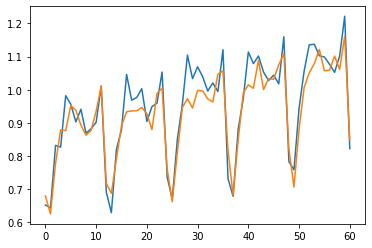

In [44]:
y_pred = model.predict(X_test)
plt.plot(y_test, label = "Test Data")
plt.plot(y_pred, label = "Pre")

### LSTM on Windows

In [45]:
X_train_t = X_train.reshape(X_train.shape[0], 1, 12)
X_test_t = X_test.reshape(X_test.shape[0], 1, 12)

In [46]:
X_train_t.shape

(228, 1, 12)

In [47]:
K.clear_session()
model = Sequential()

model.add(LSTM(6, input_shape=(1, 12)))

model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

In [48]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 6)                 456       
_________________________________________________________________
dense (Dense)                (None, 1)                 7         
Total params: 463
Trainable params: 463
Non-trainable params: 0
_________________________________________________________________


In [49]:
model.fit(X_train_t, y_train, epochs=100,
          batch_size=1, verbose=1, callbacks=[early_stop])

Epoch 1/100
228/228 [==============================] - 0s 604us/step - loss: 0.0339
Epoch 2/100
228/228 [==============================] - 0s 562us/step - loss: 0.0067
Epoch 3/100
228/228 [==============================] - 0s 571us/step - loss: 0.0057
Epoch 4/100
228/228 [==============================] - 0s 589us/step - loss: 0.0052
Epoch 5/100
228/228 [==============================] - 0s 571us/step - loss: 0.0047
Epoch 6/100
228/228 [==============================] - 0s 565us/step - loss: 0.0040
Epoch 7/100
228/228 [==============================] - 0s 555us/step - loss: 0.0038
Epoch 8/100
228/228 [==============================] - 0s 556us/step - loss: 0.0034
Epoch 9/100
228/228 [==============================] - 0s 572us/step - loss: 0.0032
Epoch 10/100
228/228 [==============================] - 0s 587us/step - loss: 0.0030
Epoch 11/100
228/228 [==============================] - 0s 584us/step - loss: 0.0027
Epoch 12/100
228/228 [==============================] - 0s 557us/step - lo

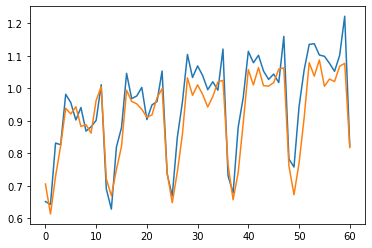

In [50]:
y_pred = model.predict(X_test_t)
plt.plot(y_test, label = "Original Prices")
plt.plot(y_pred, label = "Predicted Values")

## Exercise 1

In the model above we reshaped the input shape to: `(num_samples, 1, 12)`, i.e. we treated a window of 12 months as a vector of 12 coordinates that we simultaneously passed to all the LSTM nodes. An alternative way to look at the problem is to reshape the input to `(num_samples, 12, 1)`. This means we consider each input window as a sequence of 12 values that we will pass in sequence to the LSTM. In principle this looks like a more accurate description of our situation. But does it yield better predictions? Let's check it.

- Reshape `X_train` and `X_test` so that they represent a set of univariate sequences
- retrain the same LSTM(6) model, you'll have to adapt the `input_shape`
- check the performance of this new model, is it better at predicting the test data?

## Exercise 2

RNN models can be applied to images too. In general we can apply them to any data where there's a connnection between nearby units. Let's see how we can easily build a model that works with images.

- Load the MNIST data, by now you should be able to do it blindfolded :)
- reshape it so that an image looks like a long sequence of pixels
- create a recurrent model and train it on the training data
- how does it perform compared to a fully connected? How does it compare to Convolutional Neural Networks?

(feel free to run this exercise on a cloud GPU if it's too slow on your laptop)